In [66]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets

In [67]:
X,y = sklearn.datasets.make_moons(200,noise = 0.15)

In [68]:
X.shape

(200, 2)

In [69]:
y

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1], dtype=int64)

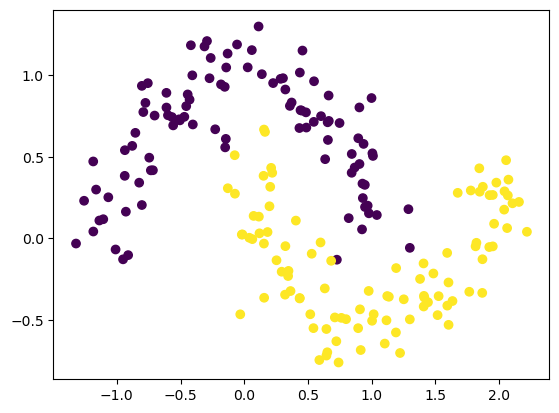

In [70]:
plt.scatter(X[:,0],X[:,1], c=y)

In [71]:
input_neurons = 2
output_neurons = 2
samples = len(X)
learning_rate=0.001
lamda = 0.01

In [72]:
samples

200

In [73]:
def retreive(model_dict):
    W1 = model_dict['W1']
    b1 = model_dict['b1']
    W2 = model_dict['W2']
    b2 = model_dict['b2']
    return W1, b1, W2, b2

In [74]:
def forward(x, model_dict):
    W1, b1, W2, b2 = retreive(model_dict)
    
    z1 = x.dot(W1) + b1               # Hidden layer linear combination
    a1 = np.tanh(z1)                  # Hidden layer activation
    z2 = a1.dot(W2) + b2              # Output layer linear combination
    exp_scores = np.exp(z2)
    softmax = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)  # Softmax activation
    
    return z1, a1, softmax


In [75]:
def loss(softmax, y, model_dict, lambda_reg=0.01):
    # Unpack weights and biases from the model dictionary
    W1, b1, W2, b2 = retreive(model_dict)
    
    # Initialize array to store correct class probabilities
    m = np.zeros_like(y, dtype=np.float32)
    
    # Loop through each sample to get the predicted probability of the correct class
    for i, correct_index in enumerate(y):
        predicted = softmax[i][correct_index]  # softmax output for true label
        m[i] = predicted
    
    # Compute negative log-likelihood (cross-entropy loss)
    log_prob = -np.log(m)
    loss = np.sum(log_prob)  # total cross-entropy loss
    
    # Add L2 regularization loss (to penalize large weights)
    reg_loss = lambda_reg / 2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    loss += reg_loss
    
    # Return average loss per sample
    return float(loss / y.shape[0])


In [76]:
def predict(model_dict, x):
    W1, b1, W2, b2 = retreive(model_dict)
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    softmax = exp_scores / np.sum(exp_scores, axis = 1, keepdims = True)   # (200,2)
    return np.argmax(softmax, axis = 1)    # (200,)

In [82]:
def backpropagation(x, y, model_dict, epochs, lambda_reg=0.01):
    for i in range(epochs):
        # Get current weights and biases from model
        W1, b1, W2, b2 = retreive(model_dict)
        
        # Perform forward pass to compute activations and predictions
        z1, a1, probs = forward(x, model_dict)  # a1: hidden layer output, probs: predicted softmax
        
        # Compute output layer error (softmax - one-hot labels)
        delta3 = np.copy(probs)
        delta3[range(x.shape[0]), y] -= 1  # subtract 1 from the true class probability
        
        # Gradients for W2 and b2 (output layer)
        dW2 = (a1.T).dot(delta3)                     # shape: (hidden_units, output_classes)
        db2 = np.sum(delta3, axis=0, keepdims=True)  # shape: (1, output_classes)
        
        # Backpropagate into hidden layer
        delta2 = delta3.dot(W2.T) * (1 - np.tanh(z1) ** 2)  # derivative of tanh
        
        # Gradients for W1 and b1 (input to hidden layer)
        dW1 = x.T.dot(delta2)              # shape: (input_features, hidden_units)
        db1 = np.sum(delta2, axis=0)       # shape: (hidden_units,)
        
        # Add L2 regularization to gradients 
        dW2 += lambda_reg * np.sum(W2)    
        dW1 += lambda_reg * np.sum(W1)     
        
        # Update weights and biases using gradient descent
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        
        # Save updated parameters back into model
        model_dict = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Print loss every 50 epochs
        if i % 50 == 0:
            print("Loss at epoch {} is: {:.3f}".format(i, loss(probs, y, model_dict)))
    
    # Return trained model
    return model_dict


In [83]:
# Define Initial Weights
def init_network(input_dim, hidden_dim, output_dim):
    model = {}
    # Xavier Initialization 
    W1 = np.random.randn(input_dim, hidden_dim) / np.sqrt(input_dim)
    b1 = np.zeros((1, hidden_dim))
    W2 = np.random.randn(hidden_dim, output_dim) / np.sqrt(hidden_dim)
    b2 = np.zeros((1, output_dim))
    model['W1'] = W1
    model['b1'] = b1
    model['W2'] = W2
    model['b2'] = b2
    return model

In [84]:
def plot_decision_boundary(pred_func): 
    # Set min and max values and give it some padding 
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5 
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5 
    h = 0.01 
    # Generate a grid of points with distance h between them 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)) 
    # Predict the function value for the whole gid 
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()]) 
    Z = Z.reshape(xx.shape) 
    # Plot the contour and training examples 
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral) 
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral) 
    plt.title("Decision Boundary for hidden layer size 3")

Loss at epoch 0 is: 0.725
Loss at epoch 50 is: 0.317
Loss at epoch 100 is: 0.280
Loss at epoch 150 is: 0.272
Loss at epoch 200 is: 0.268
Loss at epoch 250 is: 0.265
Loss at epoch 300 is: 0.263
Loss at epoch 350 is: 0.260
Loss at epoch 400 is: 0.258
Loss at epoch 450 is: 0.256
Loss at epoch 500 is: 0.254
Loss at epoch 550 is: 0.252
Loss at epoch 600 is: 0.250
Loss at epoch 650 is: 0.248
Loss at epoch 700 is: 0.246
Loss at epoch 750 is: 0.244
Loss at epoch 800 is: 0.243
Loss at epoch 850 is: 0.241
Loss at epoch 900 is: 0.239
Loss at epoch 950 is: 0.236


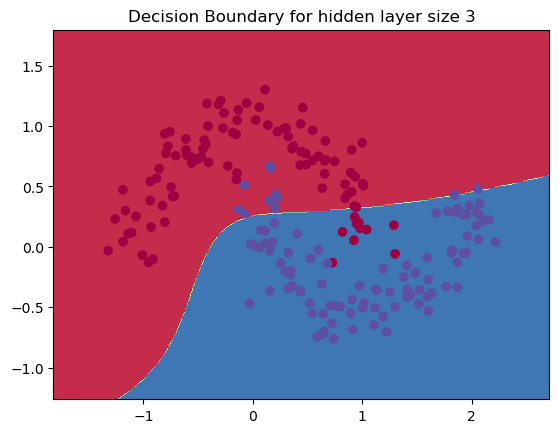

In [85]:
# starting the action
model_dict = init_network(input_dim = input_neurons , hidden_dim = 3, output_dim = output_neurons)
model = backpropagation(X, y, model_dict, 1000, lambda_reg=0.01)
plot_decision_boundary(lambda x: predict(model, x))